# Modélisation 

In [184]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [185]:
# Chargement
df_filtré = pd.read_parquet("mon_dataset.parquet", engine="pyarrow")
buildings_initial = pd.read_csv("2016_Building_Energy_Benchmarking.csv")

In [186]:
display(df_filtré.head())

,OSEBuildingID,PrimaryPropertyType,YearBuilt,PropertyGFATotal,SiteEnergyUseWN(kBtu)
0,1,Hotel,1927,88434,7456910.0
1,2,Hotel,1996,103566,8664479.0
2,5,Hotel,1926,61320,6946800.5
3,8,Hotel,1980,175580,14656503.0
4,10,Hotel,1926,83008,6062767.5


# 🔧 Feature Engineering

Dans cette partie, nous allons enrichir notre dataset avec des informations utiles pour le modèle, sans introduire de fuite de données (*data leakage*).  
L’objectif est de créer des features structurelles, liées au type d’usage et à la localisation du bâtiment.

---

### 1️⃣ Features structurelles

- **Surface totale** : `PropertyGFATotal`  
- **Nombre d’étages** : `NumberofFloors`  
- **Âge du bâtiment** : calculé comme `Age = DataYear - YearBuilt`


In [187]:
# Sélectionner uniquement les colonnes à ajouter
colonnes_a_ajouter = ["LargestPropertyUseType", "NumberofFloors", "Neighborhood", "DataYear"]


In [188]:
# Fusionner avec df_filtré sur l'ID du bâtiment
df_filtré = df_filtré.merge(buildings_initial[["OSEBuildingID"] + colonnes_a_ajouter],
                            on="OSEBuildingID",
                            how="left")

#### Création de nouvelles features

 On peut créer plusieurs types de features :
- **Structurelles** : nombre d'étages, type principal d'usage
- **Temporelles** : âge du bâtiment
- **Localisation** : quartier (Neighborhood)

On évite toute feature basée sur la consommation d'énergie pour éviter le data leakage.


In [189]:
display(df_filtré.head())

,OSEBuildingID,PrimaryPropertyType,YearBuilt,PropertyGFATotal,SiteEnergyUseWN(kBtu),LargestPropertyUseType,NumberofFloors,Neighborhood,DataYear
0,1,Hotel,1927,88434,7456910.0,Hotel,12,DOWNTOWN,2016
1,2,Hotel,1996,103566,8664479.0,Hotel,11,DOWNTOWN,2016
2,5,Hotel,1926,61320,6946800.5,Hotel,10,DOWNTOWN,2016
3,8,Hotel,1980,175580,14656503.0,Hotel,18,DOWNTOWN,2016
4,10,Hotel,1926,83008,6062767.5,Hotel,11,DOWNTOWN,2016


In [190]:
# âge du bâtiment
df_filtré["BuildingAge"] = df_filtré["DataYear"] - df_filtré["YearBuilt"]

In [191]:
# convertir NumberofFloors en feature catégorielle 
df_filtré["SmallBuilding"] = (df_filtré["NumberofFloors"] <= 3).astype(int)
df_filtré["MediumBuilding"] = ((df_filtré["NumberofFloors"] > 3) & (df_filtré["NumberofFloors"] <= 10)).astype(int)
df_filtré["TallBuilding"] = (df_filtré["NumberofFloors"] > 10).astype(int)
df_filtré.drop(columns=["NumberofFloors"], inplace=True)

In [192]:
df_filtré.head()

,OSEBuildingID,PrimaryPropertyType,YearBuilt,PropertyGFATotal,SiteEnergyUseWN(kBtu),LargestPropertyUseType,Neighborhood,DataYear,BuildingAge,SmallBuilding,MediumBuilding,TallBuilding
0,1,Hotel,1927,88434,7456910.0,Hotel,DOWNTOWN,2016,89,0,0,1
1,2,Hotel,1996,103566,8664479.0,Hotel,DOWNTOWN,2016,20,0,0,1
2,5,Hotel,1926,61320,6946800.5,Hotel,DOWNTOWN,2016,90,0,1,0
3,8,Hotel,1980,175580,14656503.0,Hotel,DOWNTOWN,2016,36,0,0,1
4,10,Hotel,1926,83008,6062767.5,Hotel,DOWNTOWN,2016,90,0,0,1


## Correlations entre Feautues / target

In [193]:
features_num= ["BuildingAge","PropertyGFATotal"]
target = "SiteEnergyUseWN(kBtu)"

Matrice de corrélation :
                        BuildingAge  PropertyGFATotal  SiteEnergyUseWN(kBtu)
BuildingAge               1.000000         -0.172102              -0.167738
PropertyGFATotal         -0.172102          1.000000               0.522794
SiteEnergyUseWN(kBtu)    -0.167738          0.522794               1.000000


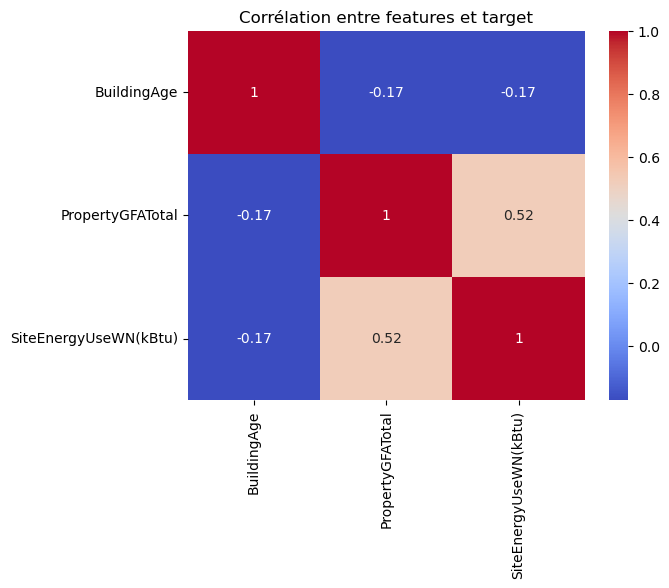

In [194]:
# Vérifier corrélation
corr_matrix = df_filtré[features_num + [target]].corr()
print("Matrice de corrélation :\n", corr_matrix)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Corrélation entre features et target")
plt.show()

## 🔍 Corrélation entre les variables

| Relation | Corrélation | Interprétation |
|-----------|--------------|----------------|
| PropertyGFATotal ↔ SiteEnergyUse(kBtu) | **0.53** | Corrélation moyenne positive |
| BuildingAge ↔ SiteEnergyUse(kBtu) | **-0.17** | Corrélation faible |
| PropertyGFATotal ↔ BuildingAge | **-0.17** | Corrélation faible |

🔴 Rouge = corrélation forte  
🔵 Bleu = corrélation faible  

**Conclusion :**  
> La taille du bâtiment (PropertyGFATotal) influence le plus la consommation d’énergie.


### Préparation du jeu de données pour la modélisation

À présent que nous avons enrichi notre DataFrame avec de nouvelles variables, 
nous allons le préparer pour l'entraînement d’un modèle : 

- Encodage des variables catégorielles
- Normalisation des variables numériques
- Séparation entraînement / test
- Sélection des variables explicatives (`X`)
- Définition de la variable cible (`y`)


In [195]:
#supprimer les features a faible correlation :  
df_filtré.drop(columns=["BuildingAge","DataYear","YearBuilt"], inplace=True)

In [196]:
df = df_filtré.copy()
# Vérifions les variables catégorielles
cat_cols = ['PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType']

# Option : ne garder que les 10 catégories les plus fréquentes dans LargestPropertyUseType
top_types = df['LargestPropertyUseType'].value_counts().nlargest(10).index
df['LargestPropertyUseType'] = df['LargestPropertyUseType'].apply(lambda x: x if x in top_types else 'Other')

# 🔹 One-Hot Encoding sur les variables sélectionnées
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df_encoded = df_encoded.dropna(subset=['SiteEnergyUseWN(kBtu)'])
# Vérifions le résultat
print(df_encoded.shape)
df_encoded.head()

(1232, 52)


,OSEBuildingID,PropertyGFATotal,SiteEnergyUseWN(kBtu),SmallBuilding,MediumBuilding,TallBuilding,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,...,Neighborhood_SOUTHWEST,LargestPropertyUseType_Hotel,LargestPropertyUseType_K-12 School,LargestPropertyUseType_Non-Refrigerated Warehouse,LargestPropertyUseType_Office,LargestPropertyUseType_Other,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Worship Facility
0,1,88434,7456910.0,0,0,1,False,True,False,False,...,False,True,False,False,False,False,False,False,False,False
1,2,103566,8664479.0,0,0,1,False,True,False,False,...,False,True,False,False,False,False,False,False,False,False
2,5,61320,6946800.5,0,1,0,False,True,False,False,...,False,True,False,False,False,False,False,False,False,False
3,8,175580,14656503.0,0,0,1,False,True,False,False,...,False,True,False,False,False,False,False,False,False,False
4,10,83008,6062767.5,0,0,1,False,True,False,False,...,False,True,False,False,False,False,False,False,False,False


### Résumé :
 - Le DataFrame filtré contient maintenant les colonnes originales pertinentes ainsi que des features nouvelles.
 - Les nouvelles features incluent le nombre d'étages en catégories, et des colonnes binaire pour le type    principal d'usage.
 - Ces features pourront être utilisées pour la modélisation sans risque de data leakage.
 - Les features ayant une corrélation faible ou négligeable avec la cible (SiteEnergyUse(kBtu)) ont été retirées du dataset.

Le DataFrame final contient donc uniquement les variables pertinentes et non redondantes, prêtes pour l’étape de modélisation.

In [197]:
# ✅ 1. Séparation des features (X) et de la cible (y)
target = "SiteEnergyUseWN(kBtu)"
X = df_encoded.drop(columns=target)
y = df_encoded[target]
print("Dimensions de X :", X.shape)
print("Dimensions de y :", y.shape)

Dimensions de X : (1232, 51)
Dimensions de y : (1232,)


In [198]:
# ✅ 2. Division du dataset en train et test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Taille du jeu d'entraînement :", X_train.shape)
print("Taille du jeu de test :", X_test.shape)



Taille du jeu d'entraînement : (985, 51)
Taille du jeu de test : (247, 51)


In [199]:
# ✅ 3. Normalisation des variables numériques
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Normalisation terminée.")

✅ Normalisation terminée.


### 🧩 Vérification et interprétation

- Le dataset a été séparé en **80 % pour l'entraînement** et **20 % pour le test**.  
- Toutes les variables numériques ont été **standardisées** :  
  - Moyenne ≈ 0  
  - Écart-type ≈ 1  
- Cette étape permet d'éviter qu'une variable ayant une grande échelle (ex. surface) domine les autres.

Le dataset est maintenant prêt pour la phase de **modélisation (entraînement du modèle)**.


# 🧠 Modélisation & Évaluation 